In [108]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.utils import resample
from sklearn.metrics import silhouette_score

In [109]:
# Most likely fix
df = pd.read_csv('Online Retail.csv', encoding='ISO-8859-1')

# Or try this if above doesn't work
# df = pd.read_csv('Online Retail.csv', encoding='cp1252')


In [110]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01/12/2010 08:26       2.55     17850.0  United Kingdom  
1  01/12/2010 08:26       3.39     17850.0  United Kingdom  
2  01/12/2010 08:26       2.75     17850.0  United Kingdom  
3  01/12/2010 08:26       3.39     17850.0  United Kingdom  
4  01/12/2010 08:26       3.39     17850.0  United Kingdom

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [112]:
# Drop rows with missing CustomerID (you can't segment anonymous customers)
df.dropna(subset=['CustomerID'], inplace=True)

In [113]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

In [114]:
# Remove transactions with negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [115]:
# Create a TotalPrice column for each transaction (Quantity √ó UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

<ipython-input-115-d0df8315d4b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


**üìä EDA: Understand the dataset**

In [116]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Duplicate rows: 5192


In [117]:
# Top 10 most purchased products
top_products = df['Description'].value_counts().head(10)
print("\nTop 10 Most Purchased Products:\n", top_products)


Top 10 Most Purchased Products:
 Description
WHITE HANGING HEART T-LIGHT HOLDER    2016
REGENCY CAKESTAND 3 TIER              1713
JUMBO BAG RED RETROSPOT               1615
ASSORTED COLOUR BIRD ORNAMENT         1395
PARTY BUNTING                         1389
LUNCH BAG RED RETROSPOT               1303
SET OF 3 CAKE TINS PANTRY DESIGN      1152
POSTAGE                               1099
LUNCH BAG  BLACK SKULL.               1078
PACK OF 72 RETROSPOT CAKE CASES       1050
Name: count, dtype: int64


<ipython-input-118-c690a894f135>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='coolwarm')


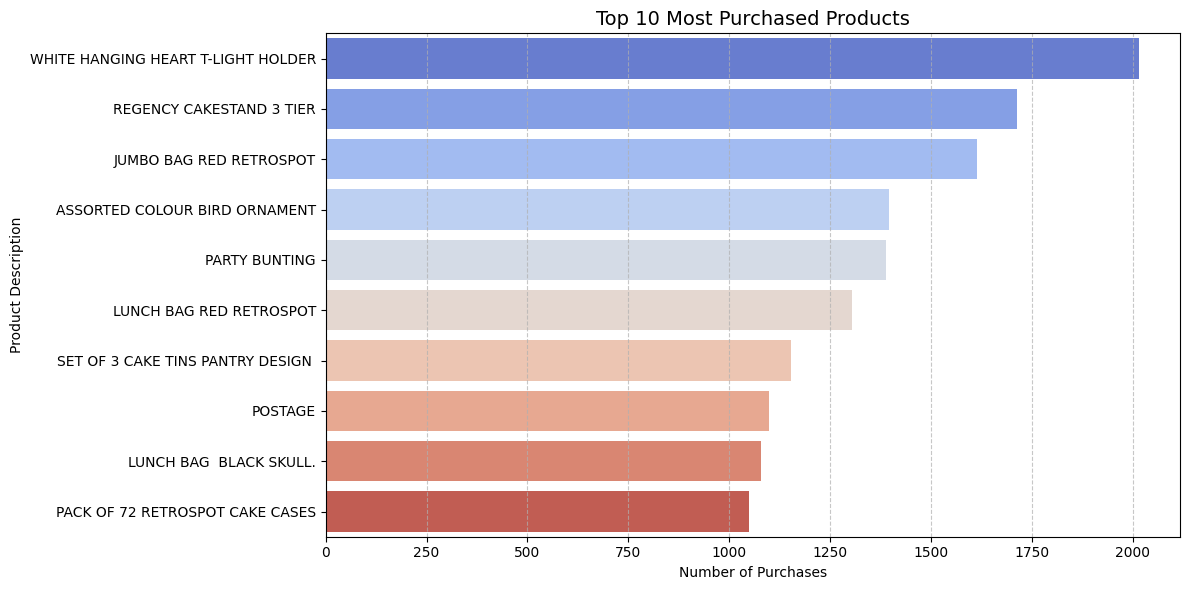

In [118]:
# Plot the top 10 most purchased products
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='coolwarm')
plt.title('Top 10 Most Purchased Products', fontsize=14)
plt.xlabel('Number of Purchases')
plt.ylabel('Product Description')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show();

In [119]:
# Count of transactions by country
top_countries = df['Country'].value_counts().head(10)
print("\nTop Countries by Transactions:\n", top_countries)


Top Countries by Transactions:
 Country
United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1453
Australia           1181
Name: count, dtype: int64


In [120]:
# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Top 10 products by revenue
revenue_by_product = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Products by Revenue:\n", revenue_by_product)


Top 10 Products by Revenue:
 Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142264.75
WHITE HANGING HEART T-LIGHT HOLDER    100392.10
JUMBO BAG RED RETROSPOT                85040.54
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68785.23
ASSORTED COLOUR BIRD ORNAMENT          56413.03
Manual                                 53419.93
RABBIT NIGHT LIGHT                     51251.24
Name: TotalPrice, dtype: float64


<ipython-input-121-10d666ab2e31>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_product.values, y=revenue_by_product.index, palette='magma')


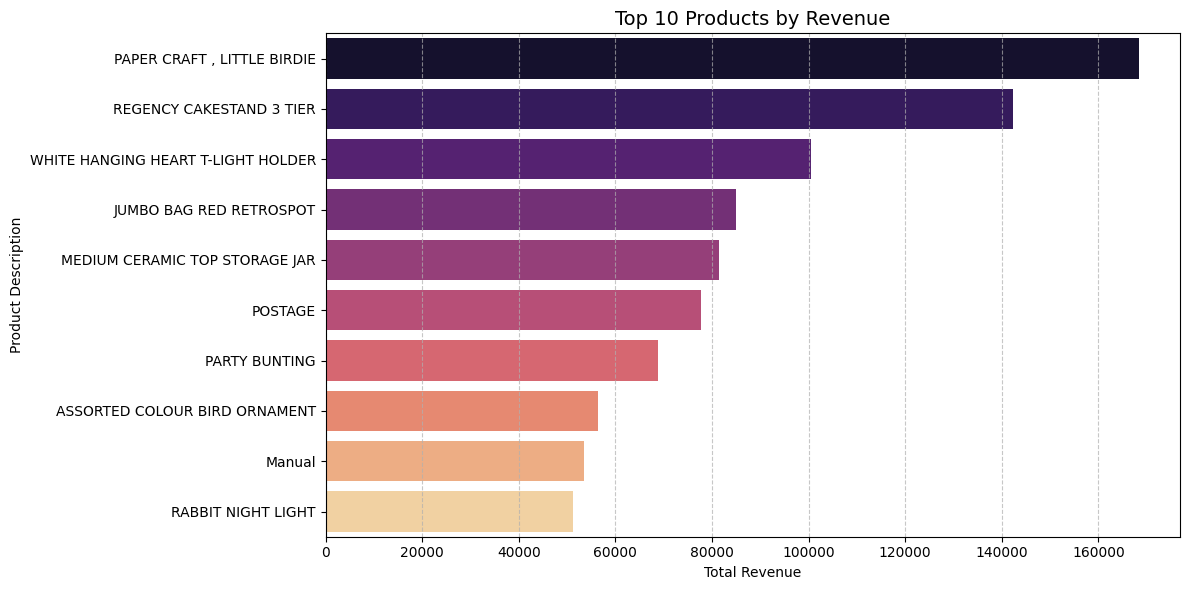

In [121]:
# Plot the top revenue-generating products
plt.figure(figsize=(12, 6))
sns.barplot(x=revenue_by_product.values, y=revenue_by_product.index, palette='magma')
plt.title('Top 10 Products by Revenue', fontsize=14)
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

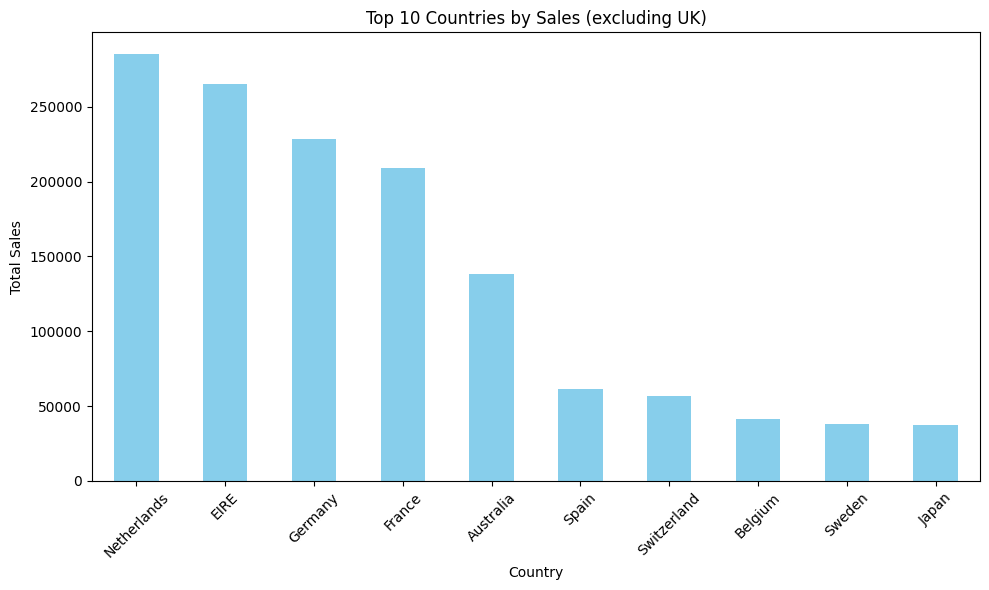

In [122]:
# Visualize total sales by country (excluding UK for better scaling)
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
country_sales = country_sales[country_sales.index != 'United Kingdom']

plt.figure(figsize=(10,6))
country_sales.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Sales (excluding UK)')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

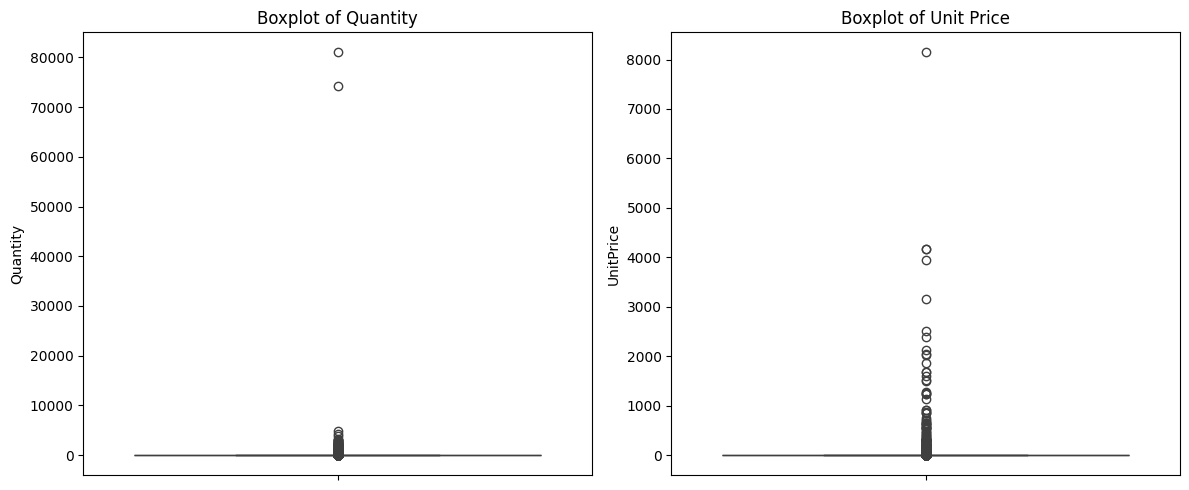

In [123]:
# Distribution of Quantity and Unit Price (outlier detection)
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(df['Quantity'], ax=ax[0])
ax[0].set_title('Boxplot of Quantity')
sns.boxplot(df['UnitPrice'], ax=ax[1])
ax[1].set_title('Boxplot of Unit Price')
plt.tight_layout()
plt.show()

**üìå RFM Feature Engineering**

In [124]:
# Set reference date for calculating "Recency"
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregate RFM metrics for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

In [125]:
# Quick check of RFM statistics
print(rfm.describe())

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2048.688081
std     100.014169     7.697998    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.000000     5.000000    1660.597500
max     374.000000   209.000000  280206.020000


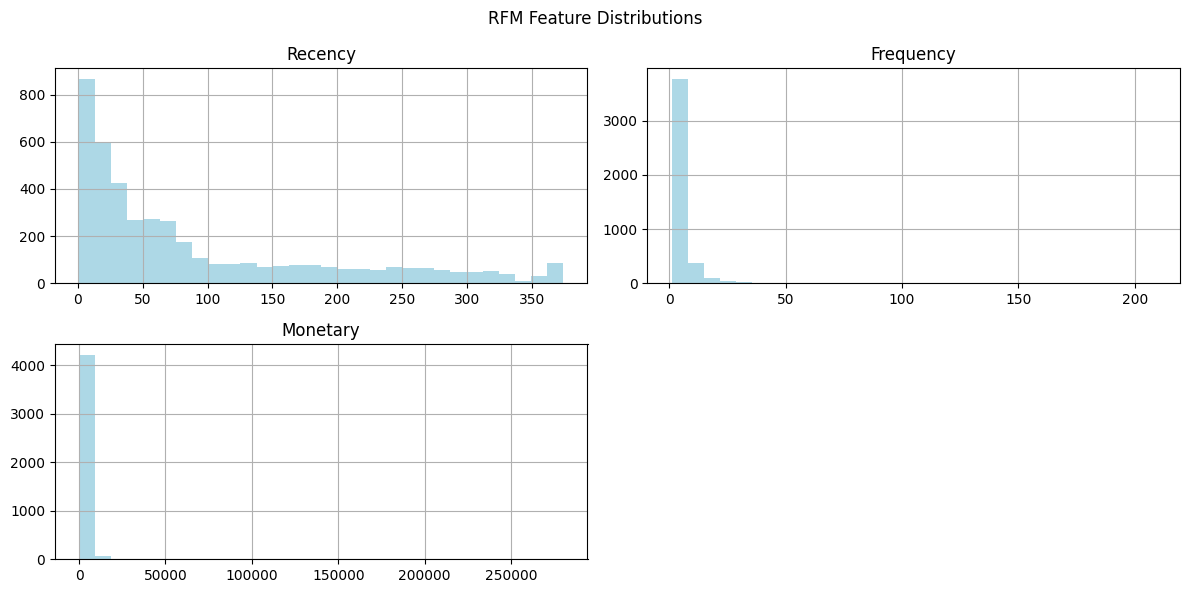

In [126]:
# Visualize distributions of R, F, M
rfm.hist(bins=30, figsize=(12, 6), color='lightblue')
plt.suptitle('RFM Feature Distributions')
plt.tight_layout()
plt.show()

**‚öñÔ∏è Feature Scaling**

In [127]:
# Standardize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

**üîç Elbow Method to choose K**

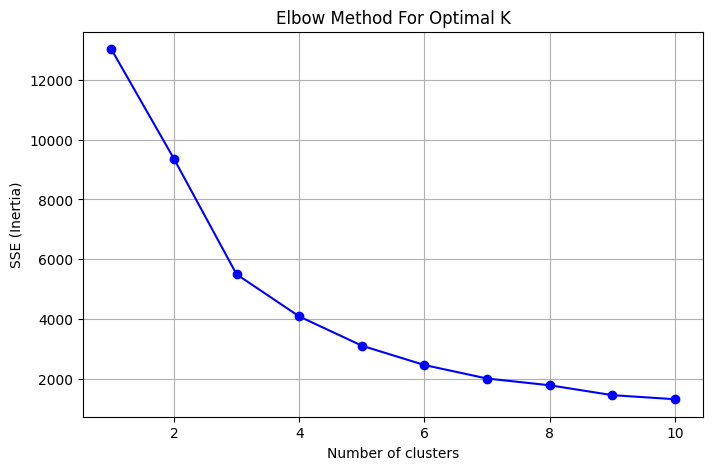

In [128]:
sse = []  # Sum of Squared Errors
K = range(1, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    sse.append(model.inertia_)

# Plot SSE for each K to find "elbow"
plt.figure(figsize=(8, 5))
plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()

**üìå Fit KMeans model (e.g., k=2)**

In [129]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster summary
cluster_summary = rfm.groupby('Cluster').mean().round(2)
print(cluster_summary)

         Recency  Frequency   Monetary
Cluster                               
0          43.70       3.68    1353.63
1         248.08       1.55     478.85
2           7.38      82.54  127187.96
3          15.50      22.33   12690.50


**Visualize clusters using PCA**

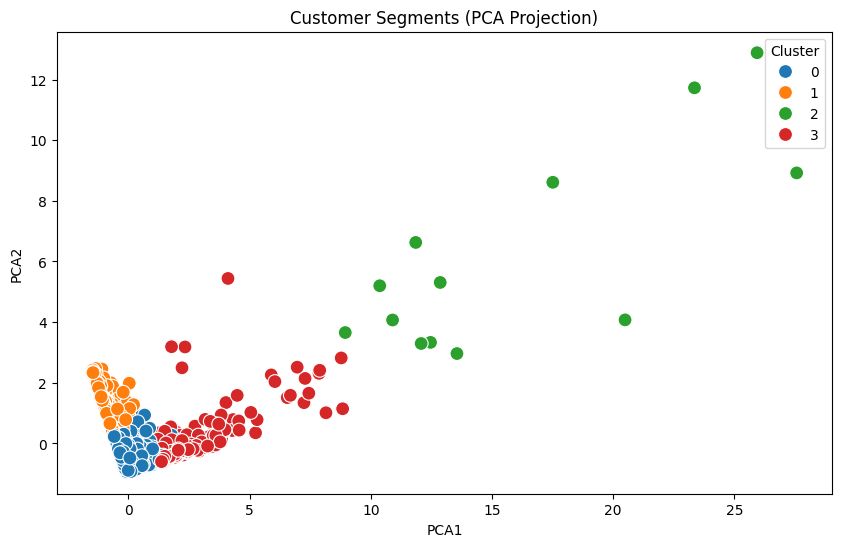

In [130]:
# Reduce dimensions to 2D for plotting
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Add PCA results to dataframe
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Scatter plot by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Segments (PCA Projection)')
plt.show()

In [131]:
# Calculate average RFM per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print(cluster_summary)


         Recency  Frequency   Monetary
Cluster                               
0          43.70       3.68    1353.63
1         248.08       1.55     478.85
2           7.38      82.54  127187.96
3          15.50      22.33   12690.50


In [132]:
segment_map = {
    0: 'Loyal Customers',
    1: 'At Risk',
    2: 'Potential Loyalists',
    3: 'Big Spenders'
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)

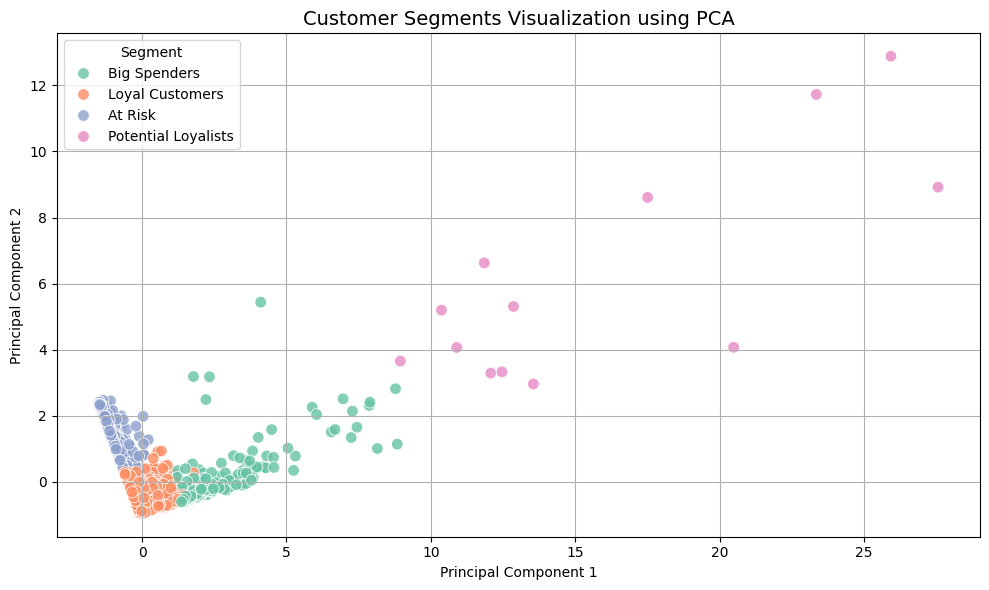

In [133]:
# Apply PCA to reduce the feature space to 2D for visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Add the 2D PCA results to your original dataframe
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Plot the PCA projection and label by segment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Segment', palette='Set2', s=70, alpha=0.8)
plt.title('Customer Segments Visualization using PCA', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Segment', loc='best')
plt.tight_layout()
plt.show()

In [134]:
# Step 1: Sample your scaled dataset (e.g., 5000 rows)
sample_size = 5000  # or 10000 depending on your system
df_sample, labels_sample = resample(
    rfm_scaled,              # your scaled RFM or feature data
    rfm['Cluster'],          # your cluster labels
    n_samples=sample_size,
    random_state=42
)

# Step 2: Compute silhouette score on the sample
score = silhouette_score(df_sample, labels_sample)
print(f"Silhouette Score (sample of {sample_size}): {score:.4f}")


Silhouette Score (sample of 5000): 0.6209


In [135]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    sample_labels = kmeans.fit_predict(df_sample)
    sil_score = silhouette_score(df_sample, sample_labels)
    print(f"k={k}, Silhouette Score: {sil_score:.4f}")

k=2, Silhouette Score: 0.9391
k=3, Silhouette Score: 0.5939
k=4, Silhouette Score: 0.6147
k=5, Silhouette Score: 0.5229
k=6, Silhouette Score: 0.5023
k=7, Silhouette Score: 0.5029
k=8, Silhouette Score: 0.4988
k=9, Silhouette Score: 0.4267
k=10, Silhouette Score: 0.4036


In [136]:
# Save model and RFM data
# Save the model
with open("rfm_kmeans_model.pkl", "wb") as model_file:
    pickle.dump(kmeans, model_file)

# Save RFM data
rfm.to_csv("rfm_data.csv", index=False)
